# Results Analysis

In [26]:
%matplotlib inline
import matplotlib as mpl
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as dates
import numpy as np
import os
import time
from datetime import timedelta

### Load dataset

In [27]:
# read from csv
input_file_name = "results_id12041022.csv"
input_file_path = os.path.join(os.path.join(os.getcwd(), "data"), input_file_name)
test =  pd.read_csv(input_file_path, index_col=[0,1])

print test.loc[20].shape[0]
test.loc[20].tail()

27856


,true,last value,previous day,previous week,offline,batch
values,,,,,,
2015-02-01 02:45:00,419.3,247.4,333.2,324.5,368.288923,447.031390
2015-02-01 03:00:00,396.1,264.5,331.5,364.3,390.589339,415.237821
2015-02-01 03:15:00,380.4,278.1,325.9,381.1,391.851389,390.150703
2015-02-01 03:30:00,396.7,244.5,328.3,386.4,395.677020,389.722084
2015-02-01 03:45:00,402.0,229.8,337.8,369.0,392.520238,411.241422


In [28]:
# read from csv
input_file_name = "id12041022_20_AR_WF_DT.csv"
input_file_path = os.path.join(os.path.join(os.getcwd(), "data", "online results", "RF100-5"), input_file_name)
a =  pd.read_csv(input_file_path, sep=';')

a.shape

(105135, 2)

The problem is that we have different sizes of datasets. Online reuslts are larger, becasue it starts to validate at the first record, while offline and batch are only evaluating the last 20%.

In [29]:
a.tail()

,target,prediction
105130,419.3,355.674441
105131,396.1,364.509561
105132,380.4,359.925331
105133,396.7,357.720270
105134,402.0,355.826422


But the tail should be the same. Checking if target is actually the same.

We should take the last chunk of the online data, the same size as offline and batch.

In [30]:
testing_set_point = test.loc[20].shape[0]
main_subset = test.loc[20]
subset = a[-testing_set_point:]

The sizes are now the same.

In [31]:
print test.loc[20].shape
print main_subset.shape
print subset.shape

(27856, 6)
(27856, 6)
(27856, 2)


The problem is that they still have different indexes.

In [32]:
main_subset.tail()

,true,last value,previous day,previous week,offline,batch
values,,,,,,
2015-02-01 02:45:00,419.3,247.4,333.2,324.5,368.288923,447.031390
2015-02-01 03:00:00,396.1,264.5,331.5,364.3,390.589339,415.237821
2015-02-01 03:15:00,380.4,278.1,325.9,381.1,391.851389,390.150703
2015-02-01 03:30:00,396.7,244.5,328.3,386.4,395.677020,389.722084
2015-02-01 03:45:00,402.0,229.8,337.8,369.0,392.520238,411.241422


In [33]:
subset.tail()

,target,prediction
105130,419.3,355.674441
105131,396.1,364.509561
105132,380.4,359.925331
105133,396.7,357.720270
105134,402.0,355.826422


We will just override index from the main dataframe, to the online subset dataframe.

In [34]:
subset.index = main_subset.index
subset.tail()

,target,prediction
values,,
2015-02-01 02:45:00,419.3,355.674441
2015-02-01 03:00:00,396.1,364.509561
2015-02-01 03:15:00,380.4,359.925331
2015-02-01 03:30:00,396.7,357.720270
2015-02-01 03:45:00,402.0,355.826422


Now we can marge.

In [35]:
#pd.concat([main_subset, subset], axis=1) # to check if target and true are the same (they are)
main_subset['online'] = subset['prediction']
main_subset.tail()

,true,last value,previous day,previous week,offline,batch,online
values,,,,,,,
2015-02-01 02:45:00,419.3,247.4,333.2,324.5,368.288923,447.031390,355.674441
2015-02-01 03:00:00,396.1,264.5,331.5,364.3,390.589339,415.237821,364.509561
2015-02-01 03:15:00,380.4,278.1,325.9,381.1,391.851389,390.150703,359.925331
2015-02-01 03:30:00,396.7,244.5,328.3,386.4,395.677020,389.722084,357.720270
2015-02-01 03:45:00,402.0,229.8,337.8,369.0,392.520238,411.241422,355.826422


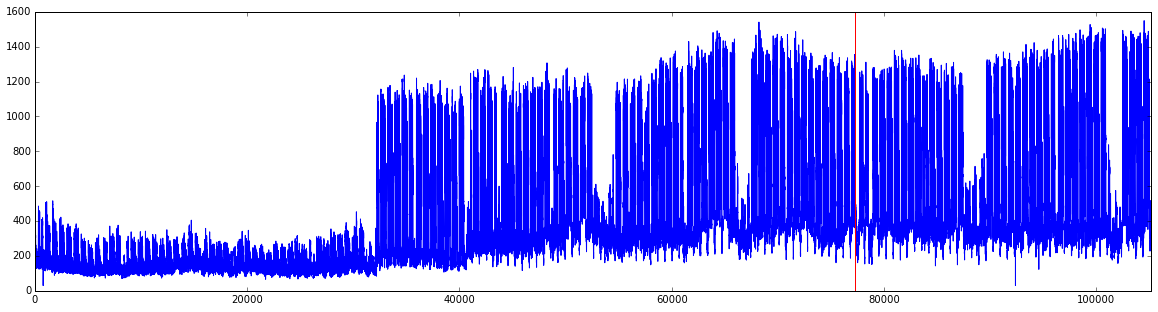

In [36]:
f = a['target'].plot(figsize=(20,5))
f.axvline(len(a)-testing_set_point, color='r')

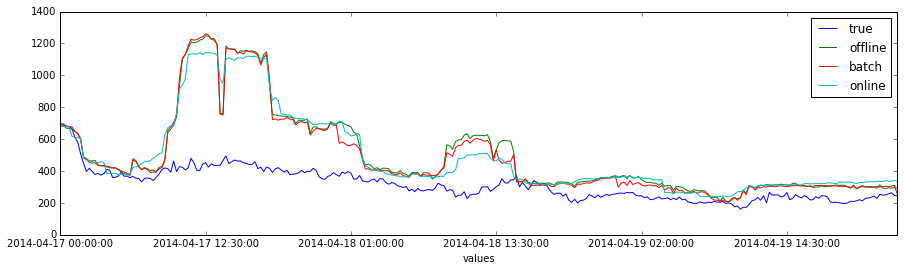

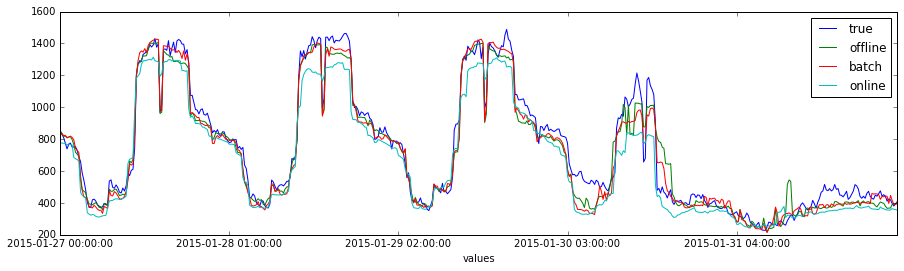

In [17]:
main_subset['2014-04-17 00:00:00':'2014-04-20 00:00:00'][['true','offline','batch', 'online']].plot(figsize=(15,4))
main_subset['2015-01-27 00:00:00':'2015-02-01 23:59:00'][['true','offline','batch', 'online']].plot(figsize=(15,4))

In [18]:
from sklearn.metrics import r2_score

def r2( g ):
    r2_lv = r2_score( g['true'], g['last value'] )
    r2_pd = r2_score( g['true'], g['previous day'] )
    r2_pw = r2_score( g['true'], g['previous week'] )
    r2_offline = r2_score( g['true'], g['offline'] )
    r2_batch = r2_score( g['true'], g['batch'] )
    r2_online = r2_score( g['true'], g['online'] )
    return pd.Series( dict(  r2_lv=r2_lv, r2_pd=r2_pd, r2_pw=r2_pw, r2_offline=r2_offline, r2_batch=r2_batch, r2_online=r2_online ) )

#subset = test['2014-04-17 00:00:00':'2014-04-27 00:00:00']
#subset = test.loc[20]['2015-01-05 00:00:00':'2015-02-01 23:59:00']
#subset = test['2014-04-17 00:00:00':'2015-02-01 23:59:00']
a=main_subset.groupby(main_subset.index.to_datetime().dayofyear, sort=False).apply(r2)
a

C:\Python27\lib\site-packages\ipykernel\__main__.py:15: FutureWarning: to_datetime is deprecated. Use pd.to_datetime(...)


,r2_batch,r2_lv,r2_offline,r2_online,r2_pd,r2_pw
107,-32.914464,-38.360762,-32.957757,-30.046152,-34.407194,-31.994377
108,-10.763516,-6.072708,-16.100379,-8.493320,-8.975007,-30.509993
109,-7.408542,-7.371814,-9.908796,-12.687695,-10.226886,-12.178210
110,-0.713478,-0.756631,-1.006294,-2.223445,-0.755013,-68.484878
111,0.797686,-1.220792,0.719216,0.481433,-1.415751,0.890173
112,0.904957,-0.657997,0.863451,0.412832,0.830351,0.898498
113,0.973686,-0.246919,0.925836,0.734859,0.955379,0.977402
114,0.951231,-0.456126,0.946016,0.796472,0.926366,-1.161121
115,0.576247,-5.700761,0.578912,0.484614,-6.067792,-1.249754
116,0.126637,-14.717097,-0.155590,0.558405,-15.666680,-0.681283


Bar plot for last month. Major improvement for batch and online is not visible.

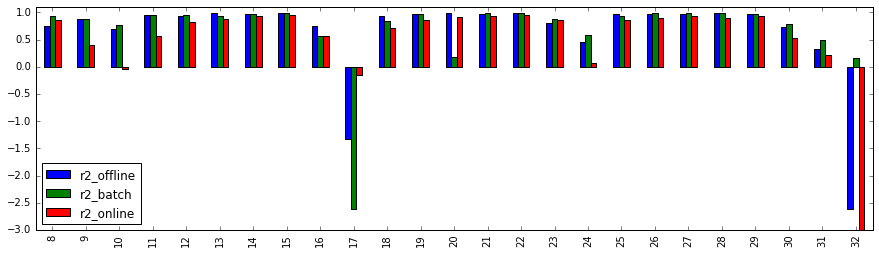

In [19]:
a[['r2_offline','r2_batch', 'r2_online']].tail(25).plot( kind='bar', figsize=(15,4), ylim=(-3, 1.1))

This can also be seen from the distribution plot

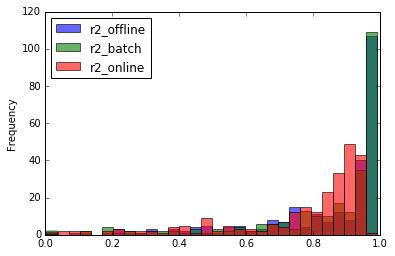

In [20]:
#subset = test.loc[20]['2014-04-17 00:00:00':'2015-02-01 23:59:00']
#main_subset['2014-04-17 00:00:00':'2015-02-01 23:59:00']
#a=subset.groupby(subset.index.to_datetime().dayofyear, sort=False).apply(r2)

b = a[['r2_offline','r2_batch', 'r2_online']]
#a[['r2_offline','r2_batch']].plot( kind='hist', figsize=(15,4))
#a[['r2_offline','r2_batch']].hist(figsize=(15,4), bins=20)
#a[['r2_offline','r2_batch']].plot.hist(bins=30)
b[b > 0].plot.hist(bins=30, alpha=0.6)

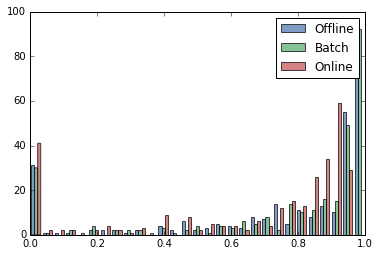

In [21]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn-deep')

b = a[['r2_offline','r2_batch', 'r2_online']]

c = b[b > 0].reset_index()[['r2_offline','r2_batch', 'r2_online']]

c = c.fillna(0)

x = c["r2_offline"].values
y = c["r2_batch"].values
z = c["r2_online"].values
data = np.vstack([x, y, z]).T
bins = np.linspace(0, 1, 30)

plt.hist(data, bins, alpha=0.7, label=['Offline', 'Batch', 'Online'])
plt.legend(loc='upper right')
plt.show()

R2 scatter plot

C:\Python27\lib\site-packages\ipykernel\__main__.py:1: FutureWarning: to_datetime is deprecated. Use pd.to_datetime(...)
  if __name__ == '__main__':


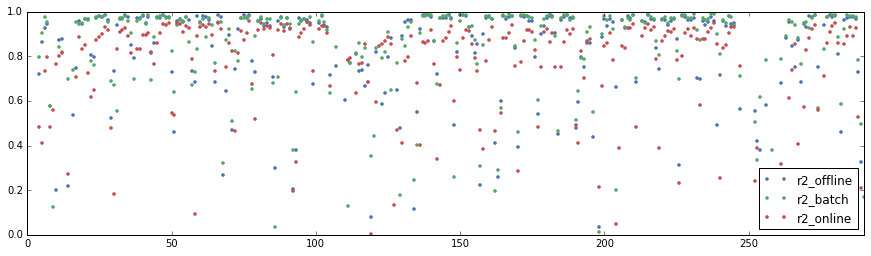

In [22]:
a=main_subset.groupby(main_subset.index.to_datetime().dayofyear, sort=False).apply(r2)

b = a[['r2_offline','r2_batch', 'r2_online']]

#a[['r2_offline','r2_batch']].plot( figsize=(15,4), marker='*')
b[b > 0].reset_index()[['r2_offline','r2_batch', 'r2_online']].plot( figsize=(15,4), marker='.', linestyle='')

Scatter plot for entire testing dataset with regression plot trend, showing that Batch is better. Unfortunatelly the trend is downword. Maybe try with different sensor.

In [23]:
a.shape

(291, 6)

C:\Python27\lib\site-packages\ipykernel\__main__.py:5: FutureWarning: to_datetime is deprecated. Use pd.to_datetime(...)


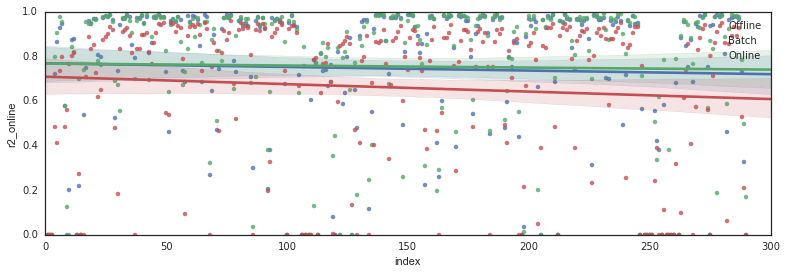

In [24]:
import seaborn as sns

sns.set_style("white")

a=main_subset.groupby(main_subset.index.to_datetime().dayofyear, sort=False).apply(r2)

#tmp = main_subset.loc['2014-04-17 00:00:00':'2015-02-01 23:59:00']
#a=tmp.groupby(tmp.index.to_datetime().dayofyear, sort=False).apply(r2)

b = a[['r2_offline','r2_batch', 'r2_online']]

#c = b.reset_index()[['r2_offline','r2_batch']]
c = b[b > 0].reset_index()[['r2_offline','r2_batch', 'r2_online']]
c = c.fillna(0)
c['index'] = c.index

plt.figure(figsize=(13,4))
#sns.pairplot(c, size=5, aspect=.8, kind="reg");
g = sns.regplot(y="r2_offline", x="index", data=c, label='Offline');
g.set(xlim=(0,300), ylim=(0,1))
sns.regplot(y="r2_batch", x="index", data=c, label='Batch');
sns.regplot(y="r2_online", x="index", data=c, label='Online');

plt.legend(loc='upper right')
plt.show()

In [25]:
import scipy

slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(x=g.get_lines()[0].get_xdata(),y=g.get_lines()[0].get_ydata())
print "Offline slope:", slope

slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(x=g.get_lines()[1].get_xdata(),y=g.get_lines()[1].get_ydata())
print "Batch slope:", slope

slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(x=g.get_lines()[2].get_xdata(),y=g.get_lines()[2].get_ydata())
print "Online slope:", slope

Offline slope: -0.000162157160073
Batch slope: -9.1600332266e-05
Online slope: -0.00033394756933


## MAPE analysis

In [26]:
import regression_metrics as additional_metrics

def mape(g):
    mape_lv = additional_metrics.mean_absolute_percentage_error( g['true'], g['last value'] )
    mape_pd = additional_metrics.mean_absolute_percentage_error( g['true'], g['previous day'] )
    mape_pw = additional_metrics.mean_absolute_percentage_error( g['true'], g['previous week'] )
    mape_offline = additional_metrics.mean_absolute_percentage_error( g['true'], g['offline'] )
    mape_batch = additional_metrics.mean_absolute_percentage_error( g['true'], g['batch'] )
    mape_online = additional_metrics.mean_absolute_percentage_error( g['true'], g['online'] )
    return pd.Series( dict(  mape_lv=mape_lv, mape_pd=mape_pd, mape_pw=mape_pw, mape_offline=mape_offline, mape_batch=mape_batch, mape_online=mape_online ) )

C:\Python27\lib\site-packages\ipykernel\__main__.py:1: FutureWarning: to_datetime is deprecated. Use pd.to_datetime(...)
  if __name__ == '__main__':


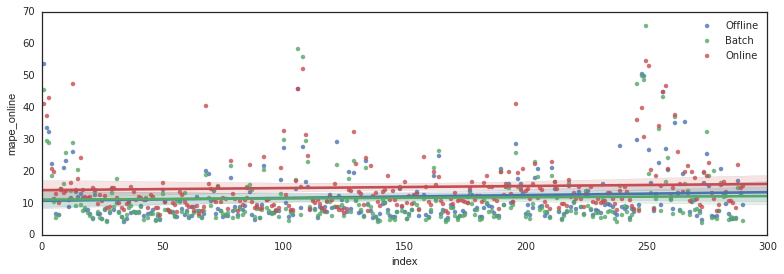

In [27]:
a=main_subset.groupby(main_subset.index.to_datetime().dayofyear, sort=False).apply(mape)

#tmp = main_subset.loc['2014-04-17 00:00:00':'2015-02-01 23:59:00']
#a=tmp.groupby(tmp.index.to_datetime().dayofyear, sort=False).apply(mape)

b = a[['mape_offline','mape_batch', 'mape_online']]

c = b[b > 0].reset_index()[['mape_offline','mape_batch', 'mape_online']]
c = c.fillna(0)
#c = b.reset_index()[['mape_offline','mape_batch']]
c['index'] = c.index

plt.figure(figsize=(13,4))
#sns.pairplot(c, size=5, aspect=.8, kind="reg");
g = sns.regplot(y="mape_offline", x="index", data=c, label='Offline');
g.set(xlim=(0,300), ylim=(0,70))
sns.regplot(y="mape_batch", x="index", data=c, label='Batch');
sns.regplot(y="mape_online", x="index", data=c, label='Online');

plt.legend(loc='upper right')
plt.show()

In [28]:
import scipy

slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(x=g.get_lines()[0].get_xdata(),y=g.get_lines()[0].get_ydata())
print "Offline slope:", slope

slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(x=g.get_lines()[1].get_xdata(),y=g.get_lines()[1].get_ydata())
print "Batch slope:", slope

slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(x=g.get_lines()[2].get_xdata(),y=g.get_lines()[2].get_ydata())
print "Online slope:", slope

Offline slope: 0.00897958613867
Batch slope: 0.00370445828936
Online slope: 0.00646172060947


In [38]:
main_subset.to_csv('./data/predictions_rf_id12041022.csv')

## Future work

- more horizons
- more sensors
- online approach